## Cart-Pole

-----

This Notebook tests the setup used in the reinforcement-learning approach using
a simpler environment, namely the Cart-Pole environment. It is adaped from
https://www.tensorflow.org/agents/tutorials/6_reinforce_tutorial
but a simpler setup of driver-replay_buffer composition is used.

In [47]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

## Hyperparameters

In [48]:
env_name = "CartPole-v0"
learning_rate = 1e-3

train_steps = 100
episodes_per_train_step = 5
episodes_per_eval_step = 1

max_episode_length = 200 # Is fixed for CartPole -> keep.
replay_buffer_capacity = episodes_per_train_step * max_episode_length + 10

log_interval = 20

fc_layer_params = (50, 50)

#### Environment

-----


In [49]:
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment

env = suite_gym.load(env_name)
tf_env = TFPyEnvironment(env)

In [50]:
time_step = tf_env.reset()
print('\nTime step:')
print(time_step)

print('\nObservation Spec:')
print(tf_env.time_step_spec().observation)

print('\nAction Spec:')
print(tf_env.action_spec())


Time step:
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.01618532,  0.02430037, -0.04200445, -0.02941378]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})

Observation Spec:
BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32))

Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64))


#### Agent

-----


In [51]:
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork

actor_net = ActorDistributionNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params
)

from tf_agents.networks.value_network import ValueNetwork

value_net = ValueNetwork(
    tf_env.observation_spec()
)

In [52]:
from tf_agents.agents import PPOAgent

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tf_agent = PPOAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
)

tf_agent.initialize()

#### Metrics

-----


In [53]:
from tf_agents.metrics.tf_metrics import AverageReturnMetric

trn_return_observer = AverageReturnMetric()
evl_return_observer = AverageReturnMetric()

#### Replay Buffer

-----

In [54]:
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer

replay_buffer = TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

#### Drivers

-----

In [55]:
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

trn_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.collect_policy,
    observers=[replay_buffer.add_batch, trn_return_observer],
    num_episodes=episodes_per_train_step
)

evl_driver = DynamicEpisodeDriver(
    tf_env,
    tf_agent.policy,
    observers=[evl_return_observer],
    num_episodes=episodes_per_eval_step
)

## Training the agent

In [56]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
from tf_agents.utils.common import function

tf_agent.train = function(tf_agent.train)
trn_driver.run = function(trn_driver.run)
evl_driver.run = function(evl_driver.run)

In [57]:
evl_returns = []
trn_returns = []

for n_episode in range(train_steps+1):

    # Eval Returns (before next training step)
    initial_time_step = tf_env.reset()
    evl_driver.run(initial_time_step)
    evl_return = evl_return_observer.result()
    evl_returns.append(evl_return)

    # Train Step
    initial_time_step = tf_env.reset()
    trn_driver.run(initial_time_step)
    trajectories = replay_buffer.gather_all()
    train_loss = tf_agent.train(experience=trajectories)  

    # Clearing Buffer
    replay_buffer.clear()

    # Train Returns
    trn_return = trn_return_observer.result()
    trn_returns.append(trn_return)

    # Logging
    if n_episode % log_interval == 0:
        print(f"\nEposide {n_episode}:")
        print(f"loss = {train_loss.loss}")
        print(f"Train Average Return = {trn_return}")
        print(f" Eval Average Return = {evl_return}")


Eposide 0:
loss = 26575.029296875
Train Average Return = 37.79999923706055
 Eval Average Return = 65.0

Eposide 20:
loss = 58367.7421875
Train Average Return = 172.3000030517578
 Eval Average Return = 196.6999969482422

Eposide 40:
loss = 23680.205078125
Train Average Return = 191.6999969482422
 Eval Average Return = 186.8000030517578

Eposide 60:
loss = 27306.90234375
Train Average Return = 185.1999969482422
 Eval Average Return = 189.39999389648438

Eposide 80:
loss = 22882.455078125
Train Average Return = 191.89999389648438
 Eval Average Return = 195.8000030517578

Eposide 100:
loss = 2025.3291015625
Train Average Return = 195.89999389648438
 Eval Average Return = 200.0


#### Return History

----

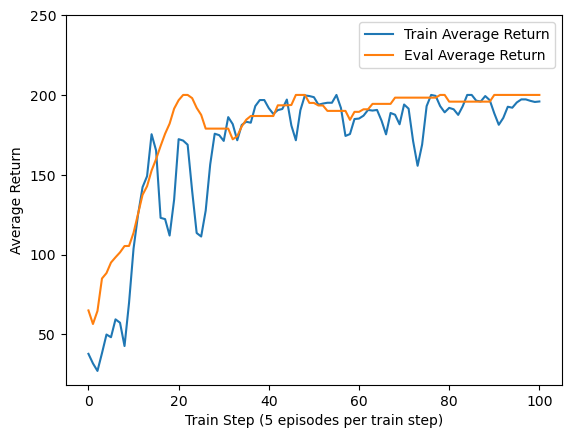

In [58]:
steps = np.arange(train_steps + 1)
plt.plot(steps, trn_returns, label="Train Average Return")
plt.plot(steps, evl_returns, label="Eval Average Return")
plt.ylabel("Average Return")
plt.xlabel(f"Train Step ({episodes_per_train_step} episodes per train step)")
plt.ylim(top=250)
plt.legend()
plt.show()